In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors as mcolors
from sklearn.model_selection import train_test_split
from scipy.linalg import svd

def load_data(filename, usecols = (), skiprows = 0, delimiter=','):
    """
    Function loads data stored in the file filename and returns it as a numpy ndarray.
    
    Inputs:
        filename: given as a string.
        
    Outputs:
        Data contained in the file, returned as a numpy ndarray
    """
    return np.loadtxt(filename, skiprows=skiprows, delimiter=delimiter, usecols= usecols)

In [4]:
movies = load_data('data/movies.txt', usecols = range(2, 20), delimiter='\t')
movies = np.concatenate((np.array([x for x in range(1, movies.shape[0] + 1)])[:, np.newaxis], movies), axis=1)
user_data = load_data('data/data.csv', skiprows = 1)

# For getting the movie names, do this instead.
import csv
with open("data/movies.txt", encoding="latin_1") as f:
    reader = csv.reader(f, delimiter="\t")
    
    # Put the contents in a matrix
    movieNames = np.array(list(reader))
    
movieNames = movieNames[:,1]

In [5]:
print(movieNames[0])

Toy Story (1995)


In [6]:
##### MATRIX FACTORIZATION METHODS FROM HW 5 HERE #####

def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    # Gradient as calculated in 2a
    gradient = (reg * Ui) - ((Yij - np.dot(Ui, Vj)) * Vj)

    return eta * gradient

def grad_U_with_bias(Ui, Yij, Vj, ai, bj, mu, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    # Gradient as calculated in 2a
    gradient = (reg * Ui) - (((Yij - mu) - (np.dot(Ui, Vj) + ai + bj)) * Vj)

    return eta * gradient

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    # Gradient as calculated in 2a
    gradient = (reg * Vj) - ((Yij - np.dot(Ui, Vj)) * Ui)

    return eta * gradient

def grad_V_with_bias(Vj, Yij, Ui, ai, bj, mu, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    # Gradient as calculated in 2a
    gradient = (reg * Vj) - (((Yij - mu) - (np.dot(Ui, Vj) + ai + bj)) * Ui)

    return eta * gradient

def grad_a(Vj, Yij, Ui, ai, bj, mu, reg, eta):
    """
    Computes the gradient with respect to ai, a trained constant
    """
    gradient = (reg * ai) - ((Yij - mu) - (np.dot(Ui, Vj) + ai + bj))
    
    return eta * gradient
    

def grad_b(Vj, Yij, Ui, ai, bj, mu, reg, eta):
    """
    Computes the gradient with respect to bj, a trained constant
    """
    gradient = (reg * bj) - ((Yij - mu) - (np.dot(Ui, Vj) + ai + bj))
    
    return eta * gradient

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    # Don't include the regularization in the error term, only need for grad update
    error = 0
    for ind in range(Y.shape[0]):
        i = Y[ind][0] - 1
        j = Y[ind][1] - 1
        Yij = Y[ind][2]
        Ui = U[i] # ith row
        Vj = V[j] # jth row
        error += ((Yij - np.dot(Ui, Vj)) ** 2) / 2

    return error / Y.shape[0] # Divide error by size of dataset to get mean err.

def get_err_with_bias(U, V, Y, a, b, mu, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    # Don't include the regularization in the error term, only need for grad update
    error = 0
    for ind in range(Y.shape[0]):
        
        i = Y[ind][0] - 1
        j = Y[ind][1] - 1
        Yij = Y[ind][2]
        Ui = U[i] # ith row
        Vj = V[j] # jth row
        ai = a[i] # ith bias
        bj = b[j] # jth bias
        error += (((Yij - mu) - (np.dot(Ui, Vj) + ai + bj)) ** 2) / 2

    return error / Y.shape[0] # Divide error by size of dataset to get mean err.

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300, useBias=False):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    # Initialize U and V
    U = np.random.rand(M, K) - 0.5
    V = np.random.rand(N, K) - 0.5
    if (useBias):
        a = np.random.rand(M) - 0.5
        b = np.random.rand(N) - 0.5
        mu = np.mean(Y[:,2])
        
    # Initialize errors
    relativeLoss = 1e5
    zerothLoss = -1
    firstLoss = -1
    lastLoss = -1
    ep = 0
    while (ep < max_epochs and relativeLoss > eps):
        
        # Shuffle the data
        np.random.shuffle(Y)
        
        # Update the U and V matrices with appropriate grad updates
        for ind in range(Y.shape[0]):
            i = Y[ind][0] - 1 # -1 to ensure 0 indexing
            j = Y[ind][1] - 1
            Yij = Y[ind][2]
            Ui = U[i] # ith row
            Vj = V[j] # jth row
            if (useBias):
                ai = a[i]
                bj = b[j]
            # Perform gradient updates
            if (useBias):
                U[i] -= grad_U_with_bias(Ui, Yij, Vj, ai, bj, mu, reg, eta)
                V[j] -= grad_V_with_bias(Vj, Yij, Ui, ai, bj, mu, reg, eta)
                a[i] -= grad_a(Vj, Yij, Ui, ai, bj, mu, reg, eta)
                b[j] -= grad_b(Vj, Yij, Ui, ai, bj, mu, reg, eta)
            else:
                U[i] -= grad_U(Ui, Yij, Vj, reg, eta)
                V[j] -= grad_V(Vj, Yij, Ui, reg, eta)
            


        # Calculate the current Error
        err = get_err_with_bias(U, V, Y, a, b, mu, reg) if useBias else get_err(U, V, Y, reg)

        # Update learnDif
        if (ep == 0):
            zerothLoss = err
        elif (ep == 1):
            firstLoss = err
        else:
            relativeLoss = (lastLoss - err) / (zerothLoss - firstLoss)

        # Set lastLoss for next epoch
        lastLoss = err


        # Next epoch
        ep += 1
        print("Epoch: ", ep, " Error: ", err)
    
    return (U, V, a, b, mu, err) if useBias else (U, V, err) 

In [60]:
# Get the data to do matrix factorization on
#Y_train, Y_test, _, __ = train_test_split(user_data.astype(int), user_data, test_size=0.1)
with open("data/train.txt", encoding="latin_1") as f:
    reader = csv.reader(f, delimiter="\t")
    
    # Put the contents in a matrix
    Y_train = np.array(list(reader)).astype(int)
    
with open("data/test.txt", encoding="latin_1") as f:
    reader = csv.reader(f, delimiter="\t")
    
    # Put the contents in a matrix
    Y_test = np.array(list(reader)).astype(int)
    
print(Y_train.shape, Y_test.shape)

(90000, 3) (10000, 3)


In [61]:
######### SECTION 1: NO BIAS TERM USED ###########

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
# K = 20 given by assignment
K= 20

reg = 0.1  # From finnnicking around, this is a good amount of regularization.
eta = 0.03 # learning rate, same from hw5

# Train model, same as HW5
U,V, err = train_model(M, N, K, eta, reg, Y_train)
test_err = get_err(U, V, Y_test)
print('Test Error: ', test_err)

# Have to transpose the matrices to be the correct shape.
U = np.transpose(U)
V = np.transpose(V)

Factorizing with  943  users,  1682  movies.
Epoch:  1  Error:  0.499334771263
Epoch:  2  Error:  0.426201123551
Epoch:  3  Error:  0.399427138165
Epoch:  4  Error:  0.382211146695
Epoch:  5  Error:  0.371688822645
Epoch:  6  Error:  0.360297532123
Epoch:  7  Error:  0.349963006407
Epoch:  8  Error:  0.343666506189
Epoch:  9  Error:  0.337356498166
Epoch:  10  Error:  0.328984167046
Epoch:  11  Error:  0.326180324498
Epoch:  12  Error:  0.319919821757
Epoch:  13  Error:  0.316401514522
Epoch:  14  Error:  0.314229941692
Epoch:  15  Error:  0.306604058941
Epoch:  16  Error:  0.301192465714
Epoch:  17  Error:  0.301494369761
Test Error:  0.446779011475


In [62]:
# Now that we have a model trained, we can go ahead and do visualizations.
# Step 1 is to perform SVD on our trained V vector
A, _, __ = svd(V, full_matrices=True)

print(U.shape, V.shape, A.shape)

# Next, we take the first two columns of A
A_two = A[:,(0,1)]

print(A_two.shape)

# Now from this, we find U_proj, V_proj using the given formulas
U_proj = np.matmul(np.transpose(A_two), U)
V_proj = np.matmul(np.transpose(A_two), V)

(20, 943) (20, 1682) (20, 20)
(20, 2)


<Figure size 432x288 with 0 Axes>

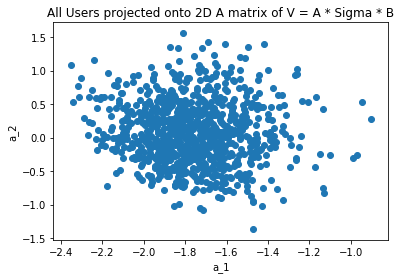

<Figure size 432x288 with 0 Axes>

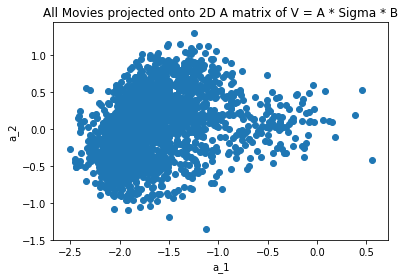

In [63]:
ux = U_proj[0]
uy = U_proj[1]

vx = V_proj[0]
vy = V_proj[1]

# TODO: Add title/legend and stuff
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(ux, uy)
plt.title('All Users projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

# TODO: Add title/legend and stuff
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(vx, vy)
plt.title('All Movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

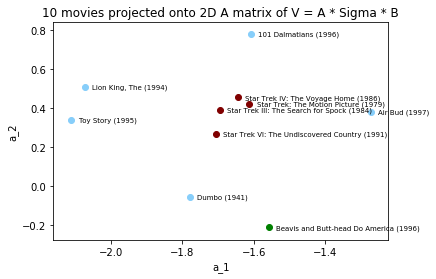

In [64]:
# Indices of 10 movies of my choosing 
# Movies: Star Trek 1,3,4,6, Dumbo, Lion King, 101 Dalmations, Air bud, Toy Story, B&BH
picked_indices = [ 226, 229, 228, 448, 500, 70, 224, 260, 0, 239]

vx1 = [vx[index] for index in picked_indices]
vy1 = [vy[index] for index in picked_indices]

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]
toUse = []
for i in [21, 21, 21, 21, 110, 110, 110, 110, 110, 81]:
    toUse.append(sorted_names[i])

plt.clf()
for i in range(len(vx1)):
    x, y = vx1[i], vy1[i]
    plt.scatter(x, y, color=toUse[i])
    plt.text(x+.02, y-.01, movieNames[picked_indices[i]], fontsize=7)

plt.title('10 movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

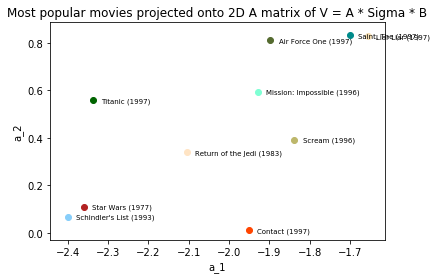

In [65]:
# Indices of 10 most popular movies (most ratings)
popularIndices = [ 49, 257, 180, 293, 287, 299, 312, 404, 747, 317]

vx2 = [vx[index] for index in popularIndices]
vy2 = [vy[index] for index in popularIndices]

toUsePop = []
for i in range(20, 121, 10):
    toUsePop.append(sorted_names[i])

plt.clf()
for i in range(len(vx2)):
    x, y = vx2[i], vy2[i]
    plt.scatter(x, y, color=toUsePop[i])
    plt.text(x+.02, y-.01, movieNames[popularIndices[i]], fontsize=7)
plt.title('Most popular movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

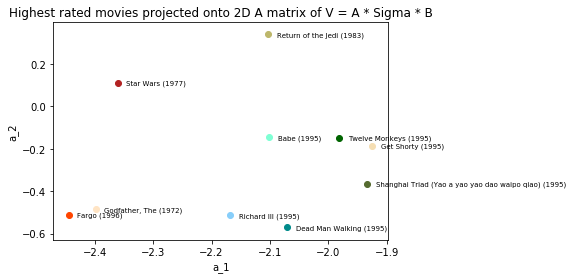

In [66]:
# Indices of 10 highest rated movies on average
highestRatedIndices = [ 49, 99, 126, 3, 180, 5, 6, 7, 8, 9]

vx3 = [vx[index] for index in highestRatedIndices]
vy3 = [vy[index] for index in highestRatedIndices]

toUseRat = []
for i in range(20, 121, 10):
    toUseRat.append(sorted_names[i])

plt.clf()
for i in range(len(vx3)):
    x, y = vx3[i], vy3[i]
    plt.scatter(x, y, color=toUseRat[i])
    plt.text(x+.015, y-.01, movieNames[highestRatedIndices[i]], fontsize=7)
plt.title('Highest rated movies projected onto 2D A matrix of V = A *data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAj0AAAEXCAYAAABGTvXMAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzs3XucTfX+x/HXZ4zLkMuQe8kplw51%0AUsnpCF1PJxIqv0QXl2Ea05CkkkspHEpESS4pl1SKk+h+UkKnThTlmnAUIbdhCDOY7++PtWbas+09%0AZhiG2e/n47Efs9da3/Vdn7XW3mt99nd91xpzziEiIiJS0EXldwAiIiIip4KSHhEREYkISnpEREQk%0AIijpERERkYigpEdEREQigpIeERERiQh5mvSY2QozuyaHZTeY2Q15ufzTlZk5M6uRzzGMNbP++RnD%0AsZjZh2bWPp9jqO7vr+j8jEM8ZtbYzH48CfXGmNkcM9tjZm/ndf2nMzOrZmb7zKxQfscicqrlOOkJ%0AlaSYWQczW5gx7Jyr65ybl4fx5YqZDTCz1/K4zizreKZyziU45wbmdxzZcc41dc5NPpE6TsZnIK+c%0ASPJrZrXM7F0z225mu8zsYzOrHTB9gJkdMrO9/muNmY02s8o5qPsaP7ZHjie245WT7eGcW+Ccq51d%0AmePUGqgIlHPO/V9QXG39450FjY82s21m1jyvg/GPM87M7shh+UnHmH6Omc00sx1+YrfMzDoAOOd+%0Acc6d5Zw7cuKRnzj/s1s9m+nXmFm6n6jtM7NfzezJUxehFCQRfXlLv+ZPHW3rE1YGmA3UxjtZfwO8%0AG1RmunOuJFAWuBWoBHybg8SnPbDL/3vaOMmfmfOANc65wyGmvYO3va8OGn8T4ICPTkI8x9wHZlbc%0AzMaZWTl/+Dy/BddCFJ8KbMRbz3LAvcBveR/28TOzPmbW2B+MNrO+ZnZlmOKb/UTtLKAREGdmrU5N%0ApFKgOOdy9AI2ADcEjesALAxVBogBJgPJwCrgEWBTUNlewA/AHmA6UCxgenNgKbAb+A/wl4BpjwK/%0AAnuBH4Hr8Q5IacAhYB/wfTbr8ai/3FQgGugNrPPrWwnc6pf9M3AQOOLXudsfXxR4FvgF70AyFogJ%0AWMbDwBZgM9AJ70BZI0w884BB/jruA+bgHaSmASnAIqB6QPmG/rg9/t+G/vg7gcVBdT8IzPbfTwIG%0AHe/2DRP7JH/d/+2X/QI4L2C6A+4HfgL+l138Aduic8BwJ/+zkwx8HFR3XX+5u/x90CfcZwAoDUz0%0A98mv/vYu5E8r5O/LHcB6P14HRIdZ5z/7ce4GVgAtgrbHi8D7/vb4L3CBP22+X+/vfmxt/PFdgLX+%0AeswGquTw+1jWr6+cPzwAeC2oTCHge+DZbOop7sd6p7/t6mdT9hpgE953eZu/PVsBzYA1/jr0CSjf%0AAPjK31ZbgNFAkXDbI6D+R4GteCfua/CPG8AF/jIu84er+PvtmtzsK+DJoM9JXIh5xwOvBI17CxiR%0A02NmLo6t5wHpwO3AYaBiNmUvxjtWrsM7vv4pTLl9QL0w06oHfsaBP/n7Yy/wqf8Zfi2obEe8JCoZ%0ASACuwDuG7gZGB9R9AfAZsNPfN9OAMmHiKAEMBlb7y701u89diH3RJ1R5vfTK7pXzgrlPeobinQRj%0AgXP8L0hw0vONf+Aqi3dyS/CnXYZ3UP0r3oG7vV++KN4v3Y34Jwf/S5lxYhlA0IE/zHosBc7FT1SA%0A//PjiMI7+P4OVA61jv64kXgnqLJASbxEZYg/7Sa8k/BF/pf6dY6d9Kz1Dxal8ZKuNcANeAnZFOBV%0Av2xZ/6Bzjz+trT9cjj9OXjUD6l4E3Om/n4Sf9Bzv9g0R+yR/mU38eUcFfR4cXmJSFi8JDht/wLbo%0A7L9v5W+XP/tl+wH/8aeVxDuJPgQU84f/Gu4zAMwCxvn7owLe5+4+f1oC3kH3XD++zwmT9ACF/Zj6%0AAEWA6/z1rx2wPXbhneyj8Q74bwZtjxoBw9fhnRgu87ffC8D8HH4fWwFbAoaPWm9//FPAf7Op5x5/%0AWxbC+xw/n03Za/BOyo/726ILsB3vM14SLxE9CJzvl78cuNLfFtXxvuM9stkeGfU/7W+PGIJOeP4y%0AV+F93j8mTEKXg30VcnsFzH8V3o+OjGNEaeAA4ROJRngJQLhXo2yW1R/4xn+/DOiZTdmL8JKe9cCr%0AQLUw5T4FvsRLZqsFTatO1qTnK7zEv4i/HikcnfSMxfuu3ejv41l436WqeMeSq/3yNYC/+/uvPF4y%0ANTJMjCXwfoCsxjtOtAhTLvgzUBPvx8t1Ofmu6KVX4CvnBb2T4r6gL/J+wic964F/BEzrzNFJz90B%0Aw88AY/33LwEDg5b/I15zcw3/S3YDUDioTLYHsoDldjpGmaVAS/99h6B1NLyk6IKAcX/jj5aMV4Ch%0AAdNqceykp2/A8HDgw4DhW4Cl/vt78A+OAdO/Ajr4718DHvff18Q7yBf3hyfxR9JzXNs3ROyTyHpS%0APwuvVexcf9gFHphyEP88/kh6PiTgFzheQrof71dxW2BJmJiyfAbwLgWlkrUlri3wuf/+M/xk2x++%0AkfBJT2O8FoiogHFvAAMCtsfLAdOaAasDhoNP8hOBZ4K23yECWvbCrOM5eAf9tsf67OMldT9lU9en%0A+Cclf7tsD7ff8U4+B/ijlaykv05/DSjzLdAqzPw9gHey2R7X4LXAFAsaF/wrfzZecvADUDTMso61%0Ar0Jur6A6fgLa+e+7EKb1+ERf/nJ6+O8fC7ccvERvPN6PnEn+d2EsYCHKxuL98FyB951cClzhT6ue%0A8RkHquElmsUD5n2No5OeqgHTd+K3VPrDMwlIZoPiaEX472ofvB9MA/COO/2AK8N87tLxzjkpfjz/%0Awm811Euv3Lxy26enlXOuTMYLSMymbBW8FoMMG0OU2Rrwfj/eQR+8L/NDZrY744X3S7yKc24t3sFz%0AALDNzN40syq5XI8ssZjZvWa2NGBZFwFnh5m3PN7B59uA8h/54+Ho9f45B/EEXms/EGI4Y7tUCVHf%0Az3i/tsD7xd3Wf98OmOWc2x9ieXm5fTPX1Tm3D6+lo0qo6TmIPzjGUQHx7cJLOKv6sa7LJqbgegoD%0AWwLqGof3KzUjppzuryrARudcejbxh/tMh6svc3n+9ttJ6O0BgJmVBz4Bxjjn3sim7gxV8bZdqLrO%0ABa7Fa5ECr49QMeDmbOrb6f7oAHvA/xvy8+p3vn7PzLaaWQrwT8J/rzJsd84dPEaZCXjf0Recc6lh%0AyuRkXx3LFLy+MOAl7CfUyT4UM7sK7/LSm/6o14GLzaxecFnn3H7nXLxzbqc//LPzblBwIcomO+d6%0AO+fq4iX+S4FZIfr/VAF2BR0nQh2rc3SMMrMK/jHjV3+fv0aYfe6c+6dzbr4/eNg5N8g593Wosnh9%0Aeso450rh9bc6wEnYH1LwncyOzFvwfpFmODcX824EBgcmWM654hkHeefc6865RngnNIfXHI7/Picy%0Ay5nZeXgH0SS8yyxlgOV4J9hQde7A+8LVDYittPM62IG33oHrWi2HMeXEZrx1DlQN71c/eCfDs/0D%0AZlu8A2gox7t9Q8lcVzM7C+8S0eaA6YHb71jxB8d4X1CMMc65//jTLggTT/D+2ojX0nN2QD2l/JMB%0A5G5/bQbONbPA7024+HMiy/YwsxJ4v+JD1mdmsXj7eLZzbvCxKvfjvAVYEKbIPXjHgDlmthWvdbYY%0Af5zoT9RLeJcuavonqz788b0KJ9vvsP8ZG4nXSjbAzMqGKZoX+2oKcL2Z/Q3vMl2471PGrfX7snk1%0ADjNre7xtstTfB//1x2e7D5xzHXK6Es65HXiXrzK6EgTaApQ1s+IB43JzrA42BG8f/sXf53dzjH3u%0AnBvgnNuQ0wU45/bg7YtbTiBOiVAnM+l5C3jMzGLNrCpeUpFTE4AEM/ureUqY2c1mVtLMapvZdWZW%0AFO/a8gG85lvwfn1UDzrQHUsJvC/pdgAz64j3KzLDb8A5ZlYEwP/lOAF4zswq+PNUNbN/BKx3BzOr%0A4x9InshFLMfyAVDLzNr5t8+2AeoA7/mxHQZmAMPwDm7/DlPP8W7fUJqZWSN/+wzE6z8S6pfiMeMP%0AMhbv81MXwMxKm1nGrcXvAZXMrIeZFfXj/qs/LctnwDm3BS9RGG5mpcwsyswuMLOr/fJvAd3Nu8U3%0AFq9Tezj/xbu0+YiZFTbvmVS38Mev9GP5DTg/YPh1oKOZ1fO39z/xtt+G4BnNrBReH5YvnXPZxYgf%0A25/xLudUAkaEKXovXqfeegGv24Gbzb9D6ASVxLscsc/MLgS6Bk0P3h45MQr41jnXGa/D+Ngw5U50%0AX+Gc+xlYiLcd/+2c25pN2QXOv7sozOuoxNPMigF3APFk3QfdgLvsBO5eM7Onzewi/3tWEm/br81o%0AJQpax8V4CWQRP8E7kWSiJH43CP+4//AJ1BWSn/jeiXfpTiRXTmbS8xTenRj/w+s3MAPvF/cxOecW%0A411DH43X0XUtXt8a8DrIDcVrcdmKd5mijz8t4yFjO83suxwuayVeP5qv8A7CF+N1AMzwGd6Xa6uZ%0A7fDHPerH9LXfhPspXgdgnHMf4v0S/cwv81lO4shhrDvx7rp6CO8yyCNAc/+XXIbX8frjvO1C3457%0AIts3lNfxErtdeB1X7zrB+DPKvoPXwvSmv42XA039aXvxOkve4sf4E95lGgj9GbgXr5PmSn99ZwAZ%0At3FPwEsmvge+w+srEC7+NKCFH8cOYAxwr3Nudbh5ggwAJvuX2e5wzs3F68Q6E+8X9wV4B/NQbsW7%0AY6ZjUAtCYMtUGzPL6Hc3G28bX+6c2xxcmXm3BlcHXnTObQ14zcb7PLQNnuc49MK7zLoXbztPD5o+%0AgIDtcazKzKwl3o0CCf6onsBlZnbUZy4P9lWGyXitcVNyOV9OtML7UTElcB/gtWIVwlvX41Uc79b7%0A3XgteOfhbY9Q7sLrl7gTr2PxdHJ4rA7hSbyO+XvwktKw36dcqpLxmce7TFmWbI41IuFYiMvBJ2dB%0AZl3x7iS6+piF5Yxg3gPSNjnn+uVRffPxOgKfjBOMiOSAmU3H64Cfl63UIqeFk9bSY2aVzewq/3JC%0Abbxf9++crOXJmc2/FHg+XsugiJwiZnaFf8k3ysxuAlri3ZIuUuCczCeeFsG7S+ZPeE2sb+I1MYtk%0A4feNWov3nJgz/l9+iJxhKuFdhiqH1yWhq3NuSf6GJHJynLLLWyIiIiL5KaL/95aIiIhEjgL5TyDP%0APvtsV7169fwOQ0TkjPLtt9/ucM6VP3ZJkTNTgUx6qlevzuLFi/M7DBGRM4qZ5eQJ8iJnLF3eEhER%0AkYigpEdEREQigpIeERERiQhKekRERCQiKOkRERGRiKCkR0RERCKCkh4RERGJCAXyOT0ikre2bl7E%0AujWzST2YTNFisVxQqwWVqlyR32GJiOSKkh4RydbWzYtYvfx10tMPAZB6MJnVy18HUOIjImcUXd4S%0AkWytWzM7M+HJkJ5+iHVrZocsP2nSJJo3b0779u15+umnw5Z57733jrns3PxD5JSUFJo1a8b48eMz%0Axw0YMIDly5cD0Lp16xzXlZOyrVu3ZvPmzTz33HNZxv/0008MGzYMgPvuu4+LL744c9r06dO59957%0AiYuLY9WqVRw5coR27drRpUsX2rdvT3p6OrNmzSIhIYGbb76Zr7/+mtTUVLp165bj2EUkPLX0iEi2%0AUg8m52o8QEJCAs2bN+fOO+8E4N///jfvv/8+Bw4c4Pbbb2fhwoXs378fgBkzZjB69Giio6NJSEhg%0AwIAB3HXXXdxyyy1ccMEFTJ06lauuuoqtW7dmSTC+/vprXnrpJZxzJCYmsnjxYnbv3s0555yTWWbh%0AwoVs27aNdu3akZaWxhNPPMHSpUsZOHAg5513Hk888QTOOUqWLMmgQYOOWo/p06fz1VdfkZKSQvfu%0A3UlJSWH8+PHUrFkTgLS0NH799dcs84wbN46HH344831gAjVz5kymTZtGcnIyffr0YeTIkRQtWpQJ%0AEyZw//338/vvv9OqVStatWrFkiVLmD9/PldeeSXFihVjy5YtVK5cOdt9JSLZU0uPiGSraLHYXI0H%0AmDBhAg0bNqR58+YAPP/885QpU4bKlSvzzTff0KhRI9q1a5c5PVidOnXo3bs35cuX56qrruLRRx9l%0A69atWcq88MILjBs3jvHjx/Piiy/SvHlzGjZsSLNmzTLLNGrUiMTERBo1asThw4fp378/Tz75JO+/%0A/z6vv/46Bw4cIDY2lvXr15OWlnZUHKNHj6ZMmTJUrFiRb775hpdeeomXX36ZhISEsOu+adMmKlas%0AGHJar1696NatG2PGjCE5OZnixYtjZtx8882kpqZSsmRJAIYNG0bnzp25/vrrAbjkkkuYP39+2GWK%0ASM6opUdEsnVBrRZZ+vQAREUV5oJaLcLO06VLF6677jruu+8+7r77btLT0+nXrx/R0d4hZ8qUKZll%0AixYtyuHDh0lNTc0cV7p06cz3JUqUAI6+1OWcw8yyjT0q6o/fdcWLFyc6OppixYqRmppKeno6N998%0AMy1ahF+PmJgYBgwYkDn8xRdfEB0dTdGiRcPOk56eHnZagwYNaNCgAWvXrmX06NF89913VK9enVde%0AeYVBgwaxdOlS6tWrx8MPP0z79u159NFHefXVV4mNjWXz5s3ZrquIHJuSHhHJVkZn5dzevVW8eHEa%0ANGjAnDlz6N69O507d6Zs2bLUr1+fSy65hMGDB3P48GFuvfVW+vfvT9WqVXMVV1JSUmaLS9euXUOW%0AueKKKxg2bBidOnU6atrdd99NUlISCxYsIC0tjVGjRmVOy0im7r77buLj44mJieHmm2/mvvvu45FH%0AHqFSpUph4ypatGhmQta3b1+WLFlCQkICo0aNYu7cucyZM4d9+/YxbNgwSpUqxfDhw0lMTGTHjh08%0A+OCDvPzyy3z//ffs2bOHLl26ALBu3TouueSSXG0fETma5aaj4Jmifv36bvHixfkdhoicgYYMGUJK%0ASgpDhgw5rvnffvttYmNjueGGG/Ispg4dOjBx4kQKFSqUZ3WGYmbfOufqn9SFiOQjtfSIiAR47LHH%0ATmj+22+/nblz5+ZRNJCamsq999570hMekUiglh4REQHU0iMFn+7eEhERkYigpEdEREQigpIeERER%0AiQhKekRERCQiKOkRERGRiKCkR0RERCKCkh4RERGJCEp6REREJCIo6REREZGIoKRHREREIoKSHhER%0AEYkISnpEREQkIijpERERkYigpEdEREQigpIeERERiQhKekRERCQiKOkRERGRiKCkR0RERCKCkh4R%0AERGJCEp6REREJCLke9JjZjeZ2Y9mttbMeoeY3tPMVprZD2Y218zOy484RURE5MyWr0mPmRUCXgSa%0AAnWAtmZWJ6jYEqC+c+4vwAzgmVMbpYiIiBQE+d3S0wBY65xb75xLA94EWgYWcM597pzb7w9+DZxz%0AimMUERGRAiC/k56qwMaA4U3+uHDigA9DTTCzeDNbbGaLt2/fnochioiISEGQ30mPhRjnQhY0uxuo%0ADwwLNd05N945V985V798+fJ5GKKIiIgUBNH5vPxNwLkBw+cAm4MLmdkNQF/gaudc6imKTURERAqQ%0A/G7pWQTUNLM/mVkR4E5gdmABM7sUGAe0cM5ty4cYRUREpADI16THOXcYSAI+BlYBbznnVpjZU2bW%0Awi82DDgLeNvMlprZ7DDViYiIiISV35e3cM59AHwQNO7xgPc3nPKgREREpMDJ78tbIiIiIqeEkh4R%0AERGJCEp6REREJCIo6REREZGIoKRHREREIoKSHhEREYkISnpEREQkIijpERERkYigpEdEREQigpIe%0AERERiQhKegqYTe++y6eNGzOnRg0+bdyYTe++m98hiYiInBaU9BQgm959lx/69uXA5s3gHAc2b+aH%0Avn1DJj4rVqygdevWJCUl8cwzzwDQunXrYy7DOQfA2rVrefDBBwF47LHHMuvo2LEjycnJYedPT08P%0AO23evHm8/vrr7Nmzh06dOnHttddmThs1ahRxcXF07tyZrVu3snLlShISEkhISOCCCy4A4JlnniEh%0AIYEmTZowbtw4tm7dyuOPPx5ucSIiEmHy/R+OSt5Z/eyzHDlwIMu4IwcOsPrZZzmnZcss4z/55BPi%0A4uJo2rQpAAsXLmTlypUMGjSITp068eKLL7Jz505uuukmWrVqRd26dbnnnnu47bbbqFWrFjVq1GD9%0A+vUAHDx4kG3btgGwe/duYmNjGThwIDt27KBSpUo89thjNG/enIYNG3L55ZczadIkzjnnHBo1akTL%0AgLhee+01xowZQ5EiRXjllVeyJGHz5s3jnXfe4ZtvvuHll1+mX79+jB07lqVLl1K2bFkAHnnkEQDa%0Atm1LmzZtKFOmDJs2bSItLY0iRYrk8dYWEZEzjVp6CpADW7bkeHxcXBwLFy4kLi6OcePG0ahRI+rU%0AqUO/fv2Ijo4mNTWVihUrMm3aNACqVKlC7969qVWrVmYd5cqVY+3atcTGxhIdHc3KlSupUaMG6enp%0ApKenU6pUKf71r38BXgvPI488QpMmTTh48CBNmzbl5ptvzhLTvn37wiYn8fHxJCYmMnv2bDZt2pQ5%0A/uWXX6ZTp06Zw1u2bCEmJoYyZcoAcP7557NkyZKcbD4RESnglPQUIDGVK+d4fKlSpRg8eDATJ05k%0A9uzZpKenY2YATJ06lRYtWtCnTx/27t0LQOnSpY+q4+qrr+app56iSZMm1K9fn6FDh3LttdeyZMkS%0AzIyBAwdy1llnAVC8eHGio6OJiYlh0qRJ7Ny5k6SkpCz1ZXfpq2nTpowZM4Zrr72WCy+8EID9+/ez%0AefNmatSokVlu4sSJdOjQIXM4NjaWlJSUsPWKiEjkUNJTgFzYqxeFYmKyjCsUE8OFvXodVXbWrFl0%0A7dqVbt26UadOHaKioihcuDD9+/enYcOGTJw4kREjRmR7Wei6667jX//6F1deeSVXX301b7/9No0b%0AN6ZGjRp8//33PPvss2zfvj3LPFu2bKFfv358+eWX1K1bN8u0woULZ75PSEhgyZIl9PJjnzp1KomJ%0Aibz++ut06dIFgOnTp2e5BOacY+HChTRp0iRz3Lp167K0TomISOSyjI6pBUn9+vXd4sWL8zuMfLHp%0A3XdZ/eyzHNiyhZjKlbmwV6+j+vOcroYPH06LFi2oWbNmntTnnKN9+/ZMmTIlT+oTKejM7FvnXP38%0AjkPkZFHSI6eNvXv3smzZMho2bJgn9W3bto2NGzdy+eWX50l9IgWdkh4p6HT3lpw2SpYsmWcJD0CF%0AChWoUKFCntUnIiJnNvXpERERkYigpEdEREQigpIeERERiQhKekRERCQiKOkRERGRiKCkR0RERCKC%0Akh4RERGJCEp6REREJCIo6REREZGIoKRHREREIoKSHhEREYkISnpEREQkIijpERERkYigpEdEREQi%0AQr4nPWZ2k5n9aGZrzax3iOlFzWy6P/2/Zlb91EcpIiIiZ7p8TXrMrBDwItAUqAO0NbM6QcXigGTn%0AXA3gOeDpUxuliIiIFAT53dLTAFjrnFvvnEsD3gRaBpVpCUz2388ArjczO4UxioiISAGQ30lPVWBj%0AwPAmf1zIMs65w8AeoFxwRWYWb2aLzWzx9u3bT1K4IiIicqbK76QnVIuNO44yOOfGO+fqO+fqly9f%0APk+CExERkYIjv5OeTcC5AcPnAJvDlTGzaKA0sOuURCciIiIFRn4nPYuAmmb2JzMrAtwJzA4qMxto%0A779vDXzmnDuqpUdEREQkO9H5uXDn3GEzSwI+BgoBrzjnVpjZU8Bi59xsYCIw1czW4rXw3Jl/EYuI%0AiMiZKl+THgDn3AfAB0HjHg94fxD4v1Mdl4iIiBQs+X15S0REROSUUNIjIiIiEUFJj4iIiEQEJT0i%0AIiISEZT0iIiISERQ0iMiIiIRQUmPiIiIRAQlPSIiIhIRlPSIiIhIRFDSIyIiIhFBSY+IiIhEBCU9%0AIiIiEhGU9IiIiEhEUNIjIiIiESFHSY+Z/cPM4sysetD4TicjKBEREZG8dsykx8z+CfQFLgbmmlm3%0AgMlJJyswERERkbyUk5aeW4DrnHM9gMuBpmb2nD/NTlpkIiIiInkoJ0lPtHPuMIBzbjdeElTKzN4G%0AipzM4ERERETySk6SnnVmdnXGgHPuiHMuDvgR+PNJi0xEREQkD+Uk6fk/4Jvgkc65fsC5GcNmVjcP%0A4xIRERHJU8dMepxzB5xzB8JM+zVgcGqeRSUiIiKSx/LyOT3q1CwiIiKnreg8rMvlYV0icpr5gd3M%0AZRt7OERpCnM9FfgLZfI7LBGRHNMTmUXkmH5gN3PYzB4OAbCHQ8xhMz+wO58jy3/Tvp5G9UerE9Ul%0AiuqPVmfa19PyOyQRCSNXSY+ZxZpZAzNrkvEKmJyWx7GJyGliLts4FNSYewjHXLaFLD9p0iSaN29O%0AYmIi3bp1C1vmvffey3EM8fHxOOeYMmUKTZo0yZz3t99+44477iAxMZGxY8cCMGrUKOLi4ujcuTNb%0At25lw4YN1KtXj4SEBGbOnAlAUlISaWkndtia9vU04qfG8/Oun3E4ft71M/FT48MmPgcOHCAhIYEW%0ALVrQuHFjEhISWLdu3TGXs3btWnr37p2r2Pr160fr1q0B2LZtGyVLlmT16tU5mtfMZuRqYdnX9byZ%0AFTOzW8zsQzNL8MeXMLNpZjbGzB7zx7Uzs8lmNtHMaptZtJmtNbOxZhbnlxlqZuXyKj6JLDm+vGVm%0AnYEHgHOApcCVwFfAdQDOuStPRoAikv8yWnhyOh4gISGB5s2b06pVKwDef/99vvjiC7Zt28aIESMA%0AeOONN/j888+pUKECjz76KIMHD2b79u3s3buXkSNHUrJkSQCWLVtGjRo1MDPuvfde0tPTM5ezcOFC%0AbrnlFu655x5at25NXFwc8+bN45133uGbb77h5Zdf5u677+ass85i//79VKtWDYAbb7yRWbNmcccd%0Adxz3dun7Tl/2p+3PMm5/2n76vtOXu66866jyMTExjB07lnnz5rF8+XLKlSvH2rVr+eyzz1i+fDmP%0APfYYI0aMoGvXrjz33HM456hZsybNmjUDYOLEiVSpUoWmTZvSvn17XnrpJYYPH87OnTvZt28fo0aN%0AokSJEpnLK1q0KFu2bGHatGkcC/6QAAAgAElEQVSZdXz55ZeMHz8e5xzdunVjz549vPjii1x55ZXg%0AHd8BLykBngOGA9WBpkBxYDrQAhgC7AHGAlOA9sBvwLPOud/8OsoDh51zB4E5ZnYAqOEv4iJguXNu%0AiJ/UVAZuBdoCFYDH8Z76vw+IATb5873lL2tEzveUiCc3LT0PAFcAPzvnrgUuBbaflKhE5LRSmsK5%0AGg8wYcIEOnfuzLnnek+2KFSoEOnp6Rw6dIhPP/0U8BKP4cOHs2jRIlasWMH8+fMpU6YMRYoUYdWq%0AVZl1LVq0iHr16oVcTrNmzfjuu+946KGHSE5OZufOncTHx5OYmMjs2bPZtGkT5513HgsXLmTs2LEM%0AHDgQgMsuu4zPP//8uLZHhl92/ZKr8cGuueYavvjiC9asWUN0dDSff/45V199NaNHj6ZEiRKUK1eO%0AZcuWZZZv3bo1M2fOZM+ePRQrVox169bxn//8hzJlyhAdHX1US84999zD1KlT+emnn6hZsyYAo0eP%0AZsKECYwbN44XXngBgEaNGvHoo48CmTu0KF4y85Rz7kegO7Ab2Az8FRgDxAPtgNeBisB6YHxGwuO7%0AFFgeZvUXAWeZ2QigMlAVL8EaDXQBzvYfjHspEAc86M/3A9AoRxtYJEhuOjIfdM4dNDPMrKhzbrWZ%0A1T5pkYnIaeN6KjCHzVkucRXGuJ4KYefp0qULzZs3Z8iQIXz//fe89NJLvPvuu0yePJn9+73WETPL%0A8rdu3boMGDDgqLp27drFRRddFHI5MTExPPec959xWrZsSYUKFWjatClNmzZl7ty5LFu2LLP+4sWL%0AZ84XGxtLSkpKLrbC0aqVrcbPu34OOT4nKleuzObNmylfvjyVK1dmxowZvPrqq3z66afcc8891KlT%0AB/AubwGULl2aw4cPM3nyZFq3bk16ejoXX3xxyG0GUL16dSZMmMAtt9ySWUeGjG0CBLYOZYw8hNeK%0Acy5eC4sBA51zRwLmPw+vtaaNc86ZWS3gITOb5pxb4BcrC6E7fjnn0vH+ryNmNhn4n3NuJ/C1f24p%0A6ZdzwGEzSzUzc84dNjP1R5XjkpukZ5OZlQFmAf82s2S8rF9ECriMu7Ryc/fW2LFj+fjjj9m5cyfd%0AunWjTp06DB48mFWrVnHDDTcA8NFHH7F06VLq169P3bp1iYqKomfPnhw4cIA+ffpkthLVqlWLDRs2%0A0KBBA9577z0mT55MTEwMZ511FldccQXdunXjyJEjtG/fnqioKKZOncpXX31Famoqzz//PAsWLGDy%0A5MkcOHCAdu3aAbBu3Tpq1ap1Qttl8K2DiZ8an+USV/EixRl86+Ac1xETE0Pt2rWpV68eb731FqVK%0AlaJ79+7069ePKlWqUKpUKdq2bZtZ/rbbbuOhhx5i9erVFCpUiMmTJ/PQQw/x+++/079/f6pWrZql%0A/unTp1OoUCH69+8PQGJiIvfddx/OOe6//3727t0bKqx0vNad0X5yNBp42T/u/9c5Nx34HIj1E547%0AgAZ4iUrg89vWANcAmNlVeFcMSpvZVufcLDMbBxQCvnLO7TSz5sDNwFl4CVQdoBde0vWpv6xYdJVB%0AjpN5SXQuZ/L+LUVp4CPn3GnXgbl+/fpu8eLF+R2GiOSRjCQoo0UnLwwePJjbb7+dCy+88ITqmfb1%0ANPq+05dfdv1CtbLVGHzr4JD9ec4EZvatc65+Dso1BroBHZ1zv2dTzoAxzrmueRhjR7xuFp/lVZ0S%0AOY7rOT3OuS/yOhARkXBiYmJo2rQpzrksl2VOxKWXXnrCCQ/AXVfedcYmOcfLv3y1IAflnJm9YWYx%0A4Z7sfxx+U8Ijx+u4WnpOd2rpEZFIcmjvJg4n/4g7cgArFEN0bG0Klzzn2DMGyWlLj8iZKi+fyCwi%0AIqfYob2bOLRzGfh9jN2RA94whEx80tLS6NWrF+np6TjnuPzyy+nUqdNR5cxshnOuddC4HkA94Hfg%0ADbzbz3c45475wCW/8/FbwXWGKBcNPO+cSzSznsDdwL3OueV+H58BwE5grnNuhpkNwrvF/QjwEF7f%0AooHACuBN59w8MxvvnIs/VoxS8CnpERE5gx1O/jEz4cnkjnA4+ceQSc+ECRMy724DOHz4MOD1cQLO%0ANbOJeIlFHTMbALzsnMt4Rs7fgVbOuUMAZlYDuMPMbsK77DTQzJ4AYvH6fd4HjAc2AP8LqPNT4G/O%0AuWFm9hwwwjm30V9GU2AegHNuhJmVCgi/KfCCc26Bmc0GZgAXOeda+Z2pbwM24j3bpxh/PNtnuZk1%0AcM59k6ONKgVWvt32Z2ZlzezfZvaT/zc2RJl6ZvaVma0wsx/MrE1+xCoicrpyR0J3lQk3fsWKFVxx%0AxRWkp6fTo0cPkpKSWLVqFfPnzwevtSQN77k5K51zAwISHoCngOfN7FUzq+uP+9g5lwRc5Cco1Z1z%0APfASlxv9MhOcc5MD6lwI/MW/I7hUQMID3vPgloZZ3anAnWY2DMh4KvO/zOwFoDHewxUXOOeaAo8C%0AT/plvgOuDVOnRJD8fNZBb7zmyZrAXH842H68Zs26wE3ASP9LIiIigBWKydX4unXrsmjRIqKiohg5%0AciQ7duwgPT2dunXrAmx2znX1W0SO6vDpnPuvfyfWY3i3koP3PB9ClA8cDlXmX8CbwOSg+bJ7ts82%0A59z9eOeLHf64Kc65bniJ0mr/+T8AyXgPWcx4Xyq4Pok8+Xl5qyX+8xvwPvTz8DLzTM65NQHvN5vZ%0ANqA8Yb4QIiKRJjq2dpY+PQBYIaJjQz87tkuXLvTq1Yv33nuP6OjoLM9IAs4xs5eAfwIrzOxZYFRG%0AS4yZPYN32agMMA2vRSiTcy7FzH42s+F4yct9QGAfnsw6gTlAL+fc/KAQ1+D924ttZtYeaA782e+7%0AsxfoA5QAhvkx9QBq4bVSPWBmtwH/8GMc7dd5gV+vRLh8u3vLzHY758oEDCc75466xBUwvQFeclQ3%0AIJMPnB6P91h0qlWrdvnPPx/9lFQRkYLoTLt7y8yKAc8DHzjnZgVNqwrEOeeeysPlvQA87pxLzqs6%0A5cx0Ult6zOxToFKISX1zWU9lvGu57UMlPADOufF4HeaoX79+wbsPX0QkjMIlzzmuJCe/+P+ANOTd%0AVM65X83sv3m8yA+U8Aic5KTHOXdDuGlm9puZVXbObfGTmm1hypUC3gf6Oee+PkmhiojIacI593Ee%0A1/dhXtYnZ6787Mg8G2jvv28PvBtcwMyKAO8AU5xzb5/C2ERERKSAyc+kZyjwdzP7Ce/ZD0MBzKy+%0Amb3sl7kDaAJ0MLOl/qte/oQrIiIiZzL9GwoREQH0byik4MvPlh4RERGRU0ZJj4iIiEQEJT0iIiIS%0AEZT0iIiISERQ0iMiIiIRQUmPiIiIRAQlPSIiIhIRlPSIiIhIRFDSIyIiIhFBSY+IiIhEBCU9IiIi%0AEhGU9IiIiEhEUNIjIiIiEUFJj4iIiEQEJT0iIiISEZT0iIiISERQ0iMiIiIRQUmPiIiIRAQlPSIi%0AIhIRlPSIiIhIRFDSIyIiIhFBSY+IiIhEBCU9IiIiEhGU9IiIiEhEUNIjIiIiEUFJj4iIiESE6PwO%0AQEREcm7Bog94Y/YL7EzeSrnYSrRt0Y3GVzTL77BEzghq6REROUMsWPQB415/ih3JW3A4diRvYdzr%0AT7Fg0Qchy69YsYLWrVuTlJTEM888A0Dr1q1POA4z62BmzY9R5ikzi/Hfx5jZWDObbWYL/PcXBJT9%0Aq5llG5iZDTKzC4PGPW9m55jZm+apbWbPn8i6nU7MbMZJqrehmd16gnUUMbPBOSx7l5ldE2L8BP9v%0AnJl9aWY3+MNVzewtMxtjZnH+uF5m9rKZTTCzs83sQjP71v8stfDLvGRm2TbmqKVHROQM8cbsF0g7%0AdDDLuLRDB3lj9gshW3s++eQT4uLiaNq0aea4tWvX0rt3b1atWsWbb77Jd999x5w5c9i6dStAUf/k%0A1BP4EqjknHvQzB4EqgGlge+AfcAdZnYT8JtzbqCZJQHnA+nOuV5++UIAzrkDQIJf90XOudFmVsPM%0AFgDvA/8DYs3sHKArcLY/fg7wMvAbcBXwWsZ6mFl54LBzbpOZTQUeAi4H4s3sEqANUAkYA6wAXgL2%0AAFudc0MC6mkJNALKA92dcyn++LuBFOfcbDN7DYgD+gCxwEbn3DAz6w7U8rdLknNujz9vXz/2ZcB0%0AoDPwiD/vIufcJDMbBJQASgIJzrnD/rx/8ZezBijmj3syh8vtD7wOdAR2AYuAOsBqoClQGXgcKAWU%0A8/fffcACINY51/8YcT0G/ARcBrQGzstJfMAMfz/MC9juV/jbB+fcRDMrzB+uAd52zr1tZrPM7BWg%0AkXOulZk1AToA7+F9DosDG/35PgeaAbMJQy09IiJniJ3JW3M1Pi4ujoULFxIXF8e4ceMAKF++PEOH%0ADuXaa69l6dKlFClShLS0NIoXLw5Qxp/1S+fc03hJA3gnnAeBDwOq/9g5lwRc5A8XAg4AfzOzCjlc%0ApeXOuaHATn/4EFAUL8m5C6gHbHDOZSQBgS4FlgM4597HOxFPdc7tBVLxEoYdQDvgZj/eB4A6ZlYs%0AoJ50/28M3sk2w3TgdjOrDawHDgMG7AZu88tc7W+D14D/C5h3LF6icyPwsb+Mwv56tvETtrP9bboo%0AaLn3AQ8Cg/GS0EK5WO48v66iQFX//Ty87VoEOAi0DNqOXzrnRgDlzaziMeLqAQzy6wIgJ/E551KB%0A4M/EFcBSQnsXaGRmz+IlU6WBV8zsRbyk5hxgjXPuaiARL5EDLyG/NkydgJIeEZEzRrnYSrkaX6pU%0AKQYPHszEiROZPXs26enplC5dGoBixYqRmprK008/zdNPP02bNm3Ab5kBfvf/mv/XBf0Fr9UEwJlZ%0AOeAS51xfvOSkeA5XaU/QcAfgX8AQvJYGA9L8aalBZcvinWgzrPdf4LX6DAUm+rFYUOyB77s45x4G%0APguM2zl3CFgFDAfGAVcC+5xzjwMHzSywzsD6cM7txEt0EvBaXloC3wJP4CUkWYoHDWes82G/jhwv%0AF/gvcAOQ4s9fxzn3I9ALeBhv2wbvm4wrPoX5IwEMF1fwOHIR35Gg+YL33x8Ldm6fc+4Bv8UwxTm3%0A2zk32zl3P16r1GrnXEasv/NHLpOM14oVli5viYicIdq26Ma415/KcomrSOFitG3RLWT5WbNm8fHH%0AHxMdHU2dOnWIijr6d26TJk144okn+P3330PUkGmhmT0HlMNLDoLtBoqbWS+8yxrH60ugC17ilAYs%0AATqaWQ/gL0Fl15C1JSLQZ0BfvJM/eJdCxppZA7wTZmAC9aOZPQZcAswKqudN4FLn3K9mdhB40F/H%0AWOecM7OFZjYK7wQevBNmAU2dcwfMbDHwJN7lP5xz281sV0BLxisB840FngI24CUKq3O6XOdcmpmd%0AjZcYVALO9Sd9hZdwnQ38EhRnQzN7Btieg7hGAuvwWo4y5DS+4KRnDVAd+MHMWuG1yO0xswN4lyOH%0A4yVi4wDMrBNQH6+VKcnMrgPa4l2Km+zXeQFHtwhmYc6FStzObPXr13eLFy/O7zBERPLcybx7y8y+%0Adc7VDzH+OrwWhCrAQ35LRr7yWxTGOOe6nqT6z8VrLRrmnAt3GSbcvH8B+gE9nHObT0Z8ecHv03OO%0Ac+7lXM43wzmX4x7xZlYLaOOcGxgwriTwuN/KlifM7ClgknNufdgy+ZX0mFlZvGum1fEy2jucc8lh%0AypbCa2Z8x79OmC0lPSIiuRcu6Tld+Z1aF/kdpeU0ZWYNgRUZHa4Dxv/DOfdxHi6nmXMu9K2Mvvzs%0A09MbmOucqwnM9YfDGQh8cUqiEhGRM4Jzbr4SntOfc+4/wQmPPz7PEh6/vmwTHsjfpKclf1yHmwy0%0AClXIzC4HKgKfnKK4REREpADKz6SnonNuC4D/96hbHM0sCq8z0zGv+ZlZvJktNrPF27dvz/NgRURE%0A5Mx2Uu/eMrNP+eM5D4H65rCKROAD59xGr89aeM658cB48Pr05CZOERERKfhOatLjnLsh3DQz+83M%0AKjvntphZZWBbiGJ/AxqbWSJwFlDEzPY557Lr/yMiIiJylPx8Ts9soD3eLYHt8Z7AmIVz7q6M92bW%0AAaivhEdERESOR3726RkK/N3MfgL+7g9jZvXNLFfPDBARERE5Fj2cUEREgDPvOT0iuaX/vSUiIiIR%0AQUmPiIiIRAQlPSIiIhIRlPSIiIhIRFDSIyIiIhFBSY+IiIhEBCU9IiIiEhGU9IiIiEhEUNIjIiIi%0AESE///dWZPt9G+z9BY6kQqGiULIalKiQ31GJiIgUWEp68sPv22DPOnDp3vCRVG8YlPiIiIicJLq8%0AlR/2/vJHwpPBpXvjg6SlpdG9e3eSkpK4//77eeWVV7Ktet68eYwePZp169bRokUL3n777aPKdOjQ%0AgX379gHQunXrHIcd/H/aPvvsMxISEqhduzadO3fm8ccfZ8CAASxfvjzHdcbHx+OcY8qUKTRp0oT3%0A3nsPgN9++4077riDxMRExo4dC8AzzzxDQkICTZo0Ydy4cSxcuJDOnTvTunVrpkyZAkBSUhJpaWk5%0AXr6IiEQO/cPR/PDrl+GnVb0qy+CLL77I+eefT9OmTQE4fPgw0dHRdO/enejoaA4dOsQLL7zAc889%0Ax88//8yePXu4/PLL2bBhAytXrqRfv3589913rF+/nqioKAYMGECjRo1o1qwZ7dq1IykpiUaNGrF0%0A6VLGjx/PoUOHGD58OM45LrjgAlq1asVdd93FLbfcQlxcHOXLlz8q5A4dOjB69GjOOussBgwYwK5d%0Au9i7dy9NmjShY8eODB48mO3bt7N3715GjhxJyZIlAVi2bBkffvghjzzyCACTJk3i7LPPpnnz5syc%0AOZP9+/dzzz330Lp1a9544w0KFy4MQNu2bXnppZcoU6ZMZgy33347M2fOZPbs2Rw8eJA77rjjhHaR%0ASCTSPxyVgk4tPfmhUNEcj1+xYgVXXHEF6enp9OjRg6SkJJYvX05sbCwjRozg7LPPZvny5cyfP5+R%0AI0dy0003AdC8eXOaNWtGw4YNOXLkCDExMXz11Vfs37+fevXq0adPHy666CIKFy7MoEGD6Ny5M198%0A8QVjxowhJiaGcuXKsWzZMgDq1KlD7969QyY8obRp04ZXX32Vjz76iFWrVjF//nzKlClDkSJFWLVq%0AVWa5RYsWUa9evZB1NGvWjO+++46HHnqI5ORkdu7cCcCWLVuIiYnJkvAMGzaMjh07AnDZZZfx+eef%0A5yhOERGJLOrTkx9KVsvapwfAorzxQerWrcuiRYto2rQpI0eOpHXr1jjnMDNvNv9vkSJFAChaNGvi%0AtHPnTr7//nteeeUVOnbsyP79+4mK+iPXLV26NADFihVj9+7dpKenc8899/CXv/wFgA0bNmSWyamM%0A8mZGeno6devWZcCAAUeV27VrFxdddFHIOmJiYnjuuecAaNmyJRUqeH2dJk6cSIcOHTLLjRgxgkqV%0AKtG8eXMAYmNjSUlJyVW8IiISGdTSE2juNLi7Ovwjyvs7d9rJWU6JClD6gj9adgoV9YZDdGLu0qUL%0AH374Iffffz8PPPAA9evX5+KLL2bHjh08/PDDbNu2jYsuuoirrrqKIUOGZPaJyVCmTBn279/Ps88+%0Ay5o1awD429/+xiOPPMIPP/xw1PKSkpJ4+umn6dWrF08++eRR0//5z3/malXr1q1LVFQUPXv2pGvX%0ArmzcuDFzWq1atdiwYQMA7733HpMnT2bMmDHMmzeP33//nU6dOtG+fXvat29PVFQUzjkWLlxIkyZN%0AAJg9ezZjx47lyy+/ZPDgwQCsW7eOWrVq5SrG08mKXUcYs/wQQ5ccYszyQ6zYdSS/QxIRKTDUpyfD%0A3GkwMh5S9/8xrmhx6DEerr8rS9FJkybx1ltvUa1aNW666SZatWoVttrAVpmceOCBBxgyZEhmh+Rm%0AzZqRlJTE/v37iY+Pp1SpUlSpUoV+/foxffp03n//fQoXLkyvXr3485//zCuvvMKSJUsoXbo0gwYN%0AYuTIkdx4443UqVMnd9sjhNWrV/Of//yHTp06nXBdAAcOHKBPnz6ZLTp5YfDgwdx+++1ceOGFeVbn%0AqbJi1xE+/CWdwwFfyWiDptWiqFu2UP4FJhFDfXqkoFNLT4ZX+2ZNeMAbfrVvyOIZdxW1atWKFStW%0A0KdPH+Li4vjqq6/YsGEDV111FUOHDmXbtm20adOG/v37c+WVVwLw5JNP0qNHDzp27JjlTqNdu3Zh%0AZhQvXpxmzZpldvAFWLVqFbVr12bMmDFs2bKFjRs3MnPmTCZOnMiQIUMYPnw427ZtY/r06ZQoUYLK%0AlSsDcO+992be/XSiLrzwwjxLeMC7hNW0adOj7go7EZdeeukZmfAAfLE5a8IDcNh540OZNGkSzZs3%0Ap3379jz99NMAPP744xw4cOCossd7l17gnX5A5t15wX8DDRw4kI0bN/LNN9/Qpk0bevXqlVlvQkIC%0ACQkJ9OzZE+ccX3zxBW3btiU+Pp758+cD0KBBAxISEhgyZAgAI0eOZOXKlTmOX0QkHCU9GbYffbt4%0AduPHjBlDQkIC33//PUWLFuXgwYNUrFiRqVOnAn90/n3rrbdITExk4MCBFC1alJSUFDZs2MDIkSO5%0A5ppr+OSTTzLrXLp0adgWmUsvvZTU1FR69uzJ5s2b+fXXX+nVqxfdunVjzJgxJCcns379esqWLcvQ%0AoUP5+eefWbduHWXLluV///vfiW2bk+jGG2/MVUvYsTRr1izP6jrVUg7lbjxAQkICkydPZsmSJQD8%0A8ssvHDlyhI8//phOnTrRs2dPfvvtN9LS0njiiSdo2bIlP/zwA5s3b6Zv374kJCQwa9YswLsUOXTo%0AUJYtW0a7du3o27dvZmf2nEpPT2ft2rWce+65NGjQIDMZAy+pP3ToEGPHjqVSpUp8+eWXzJgxg2ee%0AeYYxY8YwcuRIAEqUKEFaWhpVqlQB8jZxF5HIpo7MGcpXg20/hx4fQmJiYmbn2W7duvHwww/jnOOJ%0AJ54A/ujMG6rTcYbg4V27dmW5KylQVFQUgwYNAqBTp06cf/75VKhQgQYNGrB27VpGjx5N1apVKVu2%0ALOD15cn4hV6okC6NnAlKFQ6d4JQqHH6eCRMm8M9//pPExMQs48eNG8fMmTMzP2OHDx+mf//+LF++%0AnPfff5+4uDhSU1OpWLEi06ZNo1WrVlSpUoXevXszZ84c/v73v9OxY0e+++67XK3Dhg0bqFq1ashp%0A5cqVo27duvTo0YPk5GSqVatG9+7dGTx4MLGxsZktVHPnziUqKoo2bdpwyy23nPaJu4icOZT0ZOg4%0AOHSfno6Djznrtddey9NPP03FihWPmnbnnXfSvXt3Pv30U5xzlCpVivPOO4+HHnqIXbt2MW7cuMyy%0AtWrV4qOPPgLgq6++YsSIESQnJ1O5cmVuv/12EhMTOXToEPXr16dChQp88MEHzJkzh3379jFs2DAq%0AVapE2bJl6dmzJ2lpaVxyySWAkp4zxdVVokL26bm6SvgG2S5dunDddddx3333cffdd2eOD06oixcv%0ATnR0NMWKFSM1NZWpU6fSokUL/vrXv9KyZUsga6Ie7m7AY8kucQfo2bMnAP3796d27drUrFmTsWPH%0AkpKSQteuXQEy7y6MjY3l4MGDgD7DIpI3lPRkyOis/Gpf75JW+WpewhPUiRnIcss0wG233cZtt92W%0AZdyzzz4LeL9ua9euTUpKCnfeeSdAyNu3AS6++GLGjBkDeHdYzZ49O8v0jGkZmjVrdtTlnIEDB2YZ%0AXrBgAf/4xz9CLk9OLxmdlb/YnE7KIa+F5+oqx+7EXLx4cRo0aMCcOXMyx3Xu3Jn4+HjKlSuXmWgE%0AatiwYeadbxkJToYbb7yRBx54gO3bt2feXZdTNWvW5NVXXwVgzZo1PPnkk6xYsYLx48cTHx9P//79%0A2bFjBxUqVODSSy9l0aJFTJw4kZSUFB5//HGSk5N54IEHKFasGGXLls28xKWkR0Tygu7eOs0sWLCA%0Ayy+/nOLFi+dJfXPnzqVx48ZHndhETpbExEReeOGFPEtUFixYwKpVq4iPj8+T+iQ83b0lBZ2SHhHJ%0AU8uWLaNcuXKZrTQnSon7qaOkRwo6Xd4SkTx18cUX52l9119/fZ7WJyKRS7esi4iISERQ0iMiIiIR%0AQZe3ROSUmrZyJX0XLuSXlBSqlSrF4EaNuCsP/k2KiMixKOkRkVNm2sqVxH/yCfsPHwbg55QU4v2n%0AkivxEZGTTZe3ROSU6btwYWbCk2H/4cP0XbgwZPmM/y/2wAMP0KlTJ9avX5+r5W3YsCHzf39lKFas%0AGF9//TUAffr0ydX/JQP49NNPGTVqFAB33XUXb775JuA9ryvU3bAZ9Qcv5+GHH87VcsF7snbG07dH%0AjBjBZZddlvm/z1auXMkdd9xB165dmTFjBgD9+vUjPj6erl27sn//fubNm0fjxo1JSEhg3rx5AHoU%0AgESU/2/v/mOrru89jj9f/FCqlbsicOFCCUu01xECHblBEblWxqJyK8TpXe5NLvFmu06TWZ14cRAM%0AQUgJbvVa4zUSBb2Su6wQ17FN7bjlXrwzRifzVlw3Nu4k3K1ccivVpmIVoX3fP86haVlLj/Dt99Ce%0A1yMhPd/v93O+3/f7nFP6zufzOd+Pe3rMLDW/7+j4TPshs75YZWUlbW1t3H///Tz77LOsXbuWEydO%0A0NXVRW1tLU899RSHDh1i1KhR1NTUsGPHDvbs2UNxcfEf3S9o8eLFvPDCC8ybN48PP/ywZ//GjRs5%0AduwYU6ZMYc2aNVRWVlJRUUFzczMrV65kzpw5ACxcuJCtW7dy7733MmnSJJqamli+fDlFRUV8/PHH%0AbNq0ifb2dubOncudd97Z59rHjh3jwQcfpLq6umdpjTOvM2XKFKqqqigrK6OxsbGnQANoaGigoqIC%0AyNzduqPX69bQ0EBVVRWLFi1i2bJl3H777TQ3N7Nr1y527txJfX09paWlFBcX88knnzB9+nQAZs+e%0AzZtvvsn8+fMHe/vMhi9b7mIAAAlvSURBVD339JhZamaMH/+Z9vd2+eWXc/LkSRobGzl8+HDP+nJH%0Ajhyhq6uLoqIiXn/9dVpbW6mrq+OZZ57puQt6b6dv/FlXV8ctt9wCZBZK7e7uZvz48dTX1/e0Xbly%0AJQ888AAvvfRSz76ioiI+/fRTmpqaKC8v5+TJk7z22mtce+21SOLUqVNMmDCBnTt39rnu6aLt0Ucf%0AZerUqX2O9b7Ojh07+ixS3Nu+ffsoLy/v9/VZsWIFdXV1rFq1ira2NiDT+1RVVcWrr75KS0sLixYt%0AoqGhgUceeaRnncB58+axd+/eQV9/s5HARY+Zpab6uuu4ZEzfDuZLxoyh+rrrBn1uW1sbF110Ed3d%0A3SxcuJD169fz3HPPcemll7J//36qq6spKyujs7OTsWMzq7QOtHbYbbfdRk1NDUuWLAGgqakJSWzc%0AuJHi4mIgMww2atQoxo4dy4kTJ/o8f+7cudTW1lJRUcG0adPYvn07N9xwAy+//DKzZs1iw4YNnDpj%0AGO90r1Nra2uf/Wde52yLFJ9tbbPJkyfz5JNPsnnzZiZOnAhkVqh/4oknKC8v56qrruqzrtnpnEpK%0ASvr0GJmNZHkb3pI0AdgBzAQOA1+NiA/6aTcD2AqUAgEsjYjDqQVqZok5PVn5s3x7a8uWLTQ2NtLR%0A0cH69espLS3l7rvvZtWqVbS3t1NbW0tnZyc1NTUcPHgQyBQ169at+6Ni5bQFCxbw1ltv9RQBV1xx%0ABfv376empob33ntv0DwWL17M9u3bmTlzJtdffz2PPfYY27dvZ9y4caxevZqjR4/S1dXV5zkXX3wx%0AW7Zs4a677mLNmjUDnvvMRYp7Kysr4/Dhw0yePJnnn3+eF198kQMHDvDQQw9x2WWXsWnTJj766KOe%0A+UK1tbUcPHiQ0aNH8/jjj1NfX8/u3btpb2/nnnvuAeDdd9+lrKxs0JzNRoK8LUMh6TvA+xGxWdJq%0AoCQivt1Pu1eA6oholFQMdEdE55ntevMyFGY2XHV1dbFhwwY6OjooKyvrWX0e4MiRI2zbto1169Yl%0Adr2qqio2bNhASUmJl6GwES+fE5mXAxXZx88DrwB9ih5Js4AxEdEIEBHHU4zPzCx1o0eP5uGHH+73%0A2LRp07j66qsTvd7SpUspKSlJ9JxmF6p8zun504g4CpD9ObmfNmVAu6R6SU2SvispmaWbzcyGoRtv%0AvDHR8918882Jns/sQjakPT2S9gBT+jm0NsdTjAEWAV8Efk9mDtDfA9v6udY3gG8AzJgx4xyiNTMz%0As5FsSIueiFgy0DFJ/ydpakQclTQVaO2nWQvQFBGHss/ZBVxDP0VPRDwNPA2ZOT1JxG9mZmYjRz6H%0At34M3JF9fAfwo37a7ANKJE3Kbi8Gfp1CbGZmZjbC5LPo2Qx8WdJ/A1/ObiPpLyRtBYiILuAfgX+X%0A9EtAwDN5itfMzMyGsbx9eysi2oAv9bP/F8A/9NpuBOakGJqZmZmNQL4js5mZmRWEvN2ccChJeg/4%0An3zHkYOJwLF8B5GCQskTCidX5znyTAQujYhJg7Y0G6ZGZNEzXEj6RSHc/bRQ8oTCydV5jjyFlKsV%0ALg9vmZmZWUFw0WNmZmYFwUVPfj2d7wBSUih5QuHk6jxHnkLK1QqU5/SYmZlZQXBPj5mZmRUEFz1m%0AZmZWEFz0pEjSdyX9RtI7kn4o6XNnaTtaUpOkF9OMMQm55ClpnKQ3Je2X9CtJD+cj1vORY56lkvZK%0AOpDN8758xHq+cv3sSnpWUquk5rRjTMJnyPMmSb+V9DtJq9OOMwmS/jr7meyWNOBX1SXdJ6k52/Zb%0AacZoljQXPelqBGZHxBzgILDmLG3vAw6kElXycsnzBLA4IuYC5cBNkq5JMcYk5JLnKeCBiPgCcA3w%0ATUmzUowxKbl+dv8FuCmtoIbAoHlKGg08CdwMzAL+dpi+p83AV4CfDdRA0mzgTmA+MBeolHRlOuGZ%0AJc9FT4oi4t8i4lR28w1gen/tJE0H/grYmlZsScolz8g4nt0cm/03rGbV55jn0Yj4r+zjD8kUstPS%0AizIZuX52I+JnwPupBZawHPOcD/wuIg5FxKdAHbA8rRiTEhEHIuK3gzT7AvBGRHRmX5f/BG4d+ujM%0AhoaLnvz5GtAwwLFa4EGgO71whsyAeWaH8N4GWoHGiPh5qpEl62zvJwCSZgJfBIZznpBDriPEQHlO%0AA/7Qa7uFYVjI5qgZ+EtJl0u6BFgKlOY5JrNzlrdV1kcqSXuAKf0cWhsRP8q2WUtm2ON7/Ty/EmiN%0AiLckVQxlrOfjfPMEiIguoDw7b+KHkmZHxAU1FySJPLNtioEfAN+KiI6hiPV8JZXrhS6BPNXPvguy%0AlzKXXM8mIg5IeoTMsN9xYD+Z18VsWHLRk7CIWHK245LuACqBL0X/N0laCCyTtBQYB4yX9K8R8XfJ%0AR3vuEsiz97naJb1CZi7IBVX0JJGnpLFkCp7vRUR98lEmI8n39EKWQJ4t9O3tmA78b3IRJmewXHM8%0AxzZgG4CkTWTyNxuWPLyVIkk3Ad8GlkVEZ39tImJNREyPiJnA3wD/caEVPIPJJU9Jk05/M0ZSEbAE%0A+E16UZ6/HPMUmT8YByLin9KML0m55DoS5JjnPuBKSZ+XdBGZ39MfpxVj2iRNzv6cQWbi8/fzG5HZ%0AuXPRk65/Bi4DGiW9LWkLgKQ/k/RyfkNLVC55TgX2SnqHzB+RxogYbl/PzyXPhcAKYHG2zdvZXrzh%0AJqfPrqTvA68Dfy6pRdLX8xPuORs0z+yE3nuA3WQmpu+MiF/lK+BzJelWSS3AAuAlSbuz+8/8/+gH%0Akn4N/AT4ZkR8kIdwzRLhZSjMzMysILinx8zMzAqCix4zMzMrCC56zMzMrCC46DEzM7OC4KLHzMzM%0ACoKLHjMzMysILnrM8khStaQ/SDo+eGszMzsfLnrM8usnZFbtNjOzIeabE5oNAUm7yKzPNA54PCKe%0AHqT98YgoTiU4M7MC5aLHbAhImhAR72fXFdsHXB8RbWdp76LHzGyIeZV1s6Fxr6Rbs49LgSuBAYse%0AMzMbei56zBImqYLMqvELIqJT0itkhrnMzCyPPJHZLHl/AnyQLXiuAq7Jd0BmZuaix2wo/BQYI+kd%0AYCPwxkANJX1HUgtwiaQWSetTitHMrOB4IrOZmZkVBPf0mJmZWUHwRGazFEj6OXDxGbtXRMQv8xGP%0AmVkh8vCWmZmZFQQPb5mZmVlBcNFjZmZmBcFFj5mZmRUEFz1mZmZWEP4fiZZu8pTvQAYAAAAASUVO%0ARK5CYII= Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

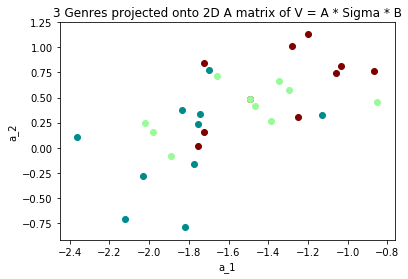

In [67]:
# Indices of 30 movies from 3 genres from Part 4
genreIndices = [137, 794,  62, 456, 621, 790, 307, 861, 622, 819, # child
                831, 422, 950, 891, 819, 559, 140, 471, 1335, 1292, # fantasy
                13, 15, 19, 32, 35, 48, 49, 50, 54, 65] # romance

vx4 = [vx[index] for index in genreIndices]
vy4 = [vy[index] for index in genreIndices]

toUseGen = []
spam = [21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 
        76, 76, 76, 76, 76, 76, 76, 76, 76, 76,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
for i in spam:
    toUseGen.append(sorted_names[i])

plt.clf()
for i in range(len(vx4)):
    x, y = vx4[i], vy4[i]
    plt.scatter(x, y, color=toUseGen[i])
    # plt.text(x+.03, y-.01, movieNames[genreIndices[i]], fontsize=7)
plt.title('3 Genres projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()


In [68]:
########### SECTION 2: MATRIX FACTORIZATION WITH BIAS ##############

# NOTE: We already have Y_train, Y_test, and K, so we do not redeclare

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies

reg = 0.1  # From finnnicking around, this is a good amount of regularization.
eta = 0.03 # learning rate, same from hw5

# Train model, same as HW5, but add in bias
Ub, Vb, a, b, mu, err = train_model(M, N, K, eta, reg, Y_train, useBias=True)
test_err = get_err_with_bias(Ub, Vb, Y_test, a, b, mu, reg)
print('Test Error: ', test_err)

# Have to transpose the matrices to be the correct shape.
Ub = np.transpose(Ub)
Vb = np.transpose(Vb)

Epoch:  1  Error:  0.422865025501
Epoch:  2  Error:  0.399592539868
Epoch:  3  Error:  0.386178494259
Epoch:  4  Error:  0.372478331404
Epoch:  5  Error:  0.359067497674
Epoch:  6  Error:  0.34807310914
Epoch:  7  Error:  0.335663048286
Epoch:  8  Error:  0.324763549475
Epoch:  9  Error:  0.316266790577
Epoch:  10  Error:  0.308618115264
Epoch:  11  Error:  0.301531037009
Epoch:  12  Error:  0.295737721319
Epoch:  13  Error:  0.289677744357
Epoch:  14  Error:  0.285236930465
Epoch:  15  Error:  0.281509088913
Epoch:  16  Error:  0.278145239023
Epoch:  17  Error:  0.274484930861
Epoch:  18  Error:  0.271754352566
Epoch:  19  Error:  0.269774923166
Epoch:  20  Error:  0.266464768441
Epoch:  21  Error:  0.264642687858
Epoch:  22  Error:  0.263386806631
Epoch:  23  Error:  0.26158460865
Epoch:  24  Error:  0.260295595821
Epoch:  25  Error:  0.258824492531
Epoch:  26  Error:  0.257335195562
Epoch:  27  Error:  0.256314847943
Epoch:  28  Error:  0.255121864347
Epoch:  29  Error:  0.254889337

In [69]:
# Now that we have a model trained, we can go ahead and do visualizations.
# Step 1 is to perform SVD on our trained V vector
Ab, _, __ = svd(Vb, full_matrices=True)

print(U.shape, Vb.shape, A.shape)

# Next, we take the first two columns of A
Ab_two = Ab[:,(0,1)]

print(Ab_two.shape)

# Now from this, we find U_proj, V_proj using the given formulas
Ub_proj = np.matmul(np.transpose(Ab_two), Ub)
Vb_proj = np.matmul(np.transpose(Ab_two), Vb)

(20, 943) (20, 1682) (20, 20)
(20, 2)


<Figure size 432x288 with 0 Axes>

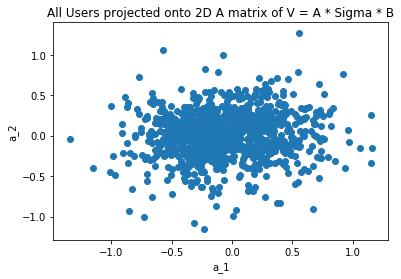

<Figure size 432x288 with 0 Axes>

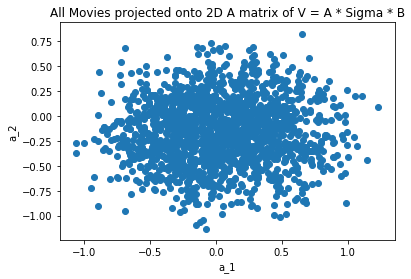

In [70]:
ubx = Ub_proj[0]
uby = Ub_proj[1]

vbx = Vb_proj[0]
vby = Vb_proj[1]

# TODO: Add title/legend and stuff
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(ubx, uby)
plt.title('All Users projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

# TODO: Add title/legend and stuff
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(vbx, vby)
plt.title('All Movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

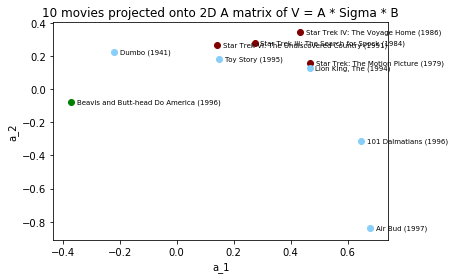

In [71]:
vbx1 = [vbx[index] for index in picked_indices]
vby1 = [vby[index] for index in picked_indices]

plt.clf()
for i in range(len(vbx1)):
    x, y = vbx1[i], vby1[i]
    plt.scatter(x, y, color=toUse[i])
    plt.text(x+.02, y-.01, movieNames[picked_indices[i]], fontsize=7)
plt.title('10 movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

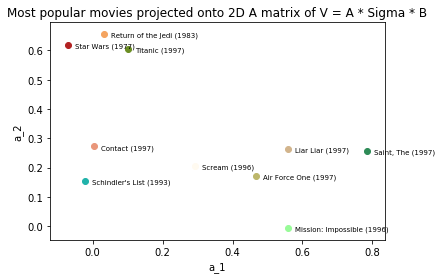

In [72]:
vbx2 = [vbx[index] for index in popularIndices]
vby2 = [vby[index] for index in popularIndices]

toUsePop = []
for i in range(20, 101, 8):
    toUsePop.append(sorted_names[i])

plt.clf()
for i in range(len(vbx2)):
    x, y = vbx2[i], vby2[i]
    plt.scatter(x, y, color=toUsePop[i])
    plt.text(x+.02, y-.01, movieNames[popularIndices[i]], fontsize=7)
plt.title('Most popular movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

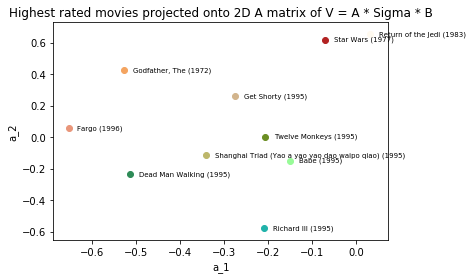

In [73]:
vbx3 = [vbx[index] for index in highestRatedIndices]
vby3 = [vby[index] for index in highestRatedIndices]

toUseRat = []
for i in range(20, 101, 8):
    toUseRat.append(sorted_names[i])

plt.clf()
for i in range(len(vbx3)):
    x, y = vbx3[i], vby3[i]
    plt.scatter(x, y, color=toUseRat[i])
    plt.text(x+.02, y-.01, movieNames[highestRatedIndices[i]], fontsize=7)
plt.title('Highest rated movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

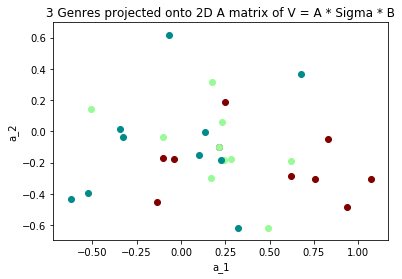

In [74]:
vbx4 = [vbx[index] for index in genreIndices]
vby4 = [vby[index] for index in genreIndices]

toUseGen = []
spam = [21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 
        76, 76, 76, 76, 76, 76, 76, 76, 76, 76,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
for i in spam:
    toUseGen.append(sorted_names[i])

plt.clf()
for i in range(len(vbx4)):
    x, y = vbx4[i], vby4[i]
    plt.scatter(x, y, color=toUseGen[i])
    # plt.text(x+.02, y-.01, movieNames[genreIndices[i]], fontsize=7)
plt.title('3 Genres projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

In [75]:
remove = [1349,1363,1458,1541,1561,1576,1579,1581,1606,1633,1651,1666,1667,1678]
movieNamesSurprise = movieNames.copy()
for i in range(len(remove)):
    ind = len(remove) - i - 1
    movieNamesSurprise = np.delete(movieNamesSurprise, remove[ind])
    
print(len(movieNamesSurprise))

1668


In [97]:
########### SECTION 3: OFF-THE-SHELF RECOMMENDER ##############

# NOTE: We already have Y_train, Y_test, so we do not redeclare
from surprise import SVD
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import KFold
import pandas as pd


M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies

reg = 0.1  # From finnnicking around, this is a good amount of regularization.
eta = 0.03 # learning rate, same from hw5

ratings_dict_train = {'itemID': Y_train[:,1],
                    'userID': Y_train[:,0],
                    'rating': Y_train[:,2]}

ratings_dict_test = {'itemID': Y_test[:,1],
                    'userID': Y_test[:,0],
                    'rating': Y_test[:,2]}

df_train = pd.DataFrame(ratings_dict_train)
df_test = pd.DataFrame(ratings_dict_test)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
datatrain = Dataset.load_from_df(df_train[['userID', 'itemID', 'rating']], reader)
datatest = Dataset.load_from_df(df_test[['userID', 'itemID', 'rating']], reader)

trainset = datatrain.build_full_trainset()

kf = KFold(n_splits=2)
for _, testset in kf.split(datatest):
    pass

# We'll use the famous SVD algorithm.
algo = SVD(n_factors=K, n_epochs=60, lr_all=0.03, reg_all=0.1, verbose=True)

# Train the algorithm on the trainset, and predict ratings for the testset
model = algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

0.91488382772431165

In [98]:
V_surprise = np.transpose(model.qi)
U_surprise = np.transpose(model.pu)

In [99]:
# Now that we have a model trained, we can go ahead and do visualizations.
# Step 1 is to perform SVD on our trained V vector
A_surprise, _, __ = svd(V_surprise, full_matrices=True)

print(U_surprise.shape, V_surprise.shape, A_surprise.shape)

# Next, we take the first two columns of A
A_surprise_two = A_surprise[:,(0,1)]

print(A_surprise_two.shape)

# Now from this, we find U_proj, V_proj using the given formulas
U_surprise_proj = np.matmul(np.transpose(A_surprise_two), U_surprise)
V_surprise_proj = np.matmul(np.transpose(A_surprise_two), V_surprise)

(20, 943) (20, 1668) (20, 20)
(20, 2)


<Figure size 432x288 with 0 Axes>

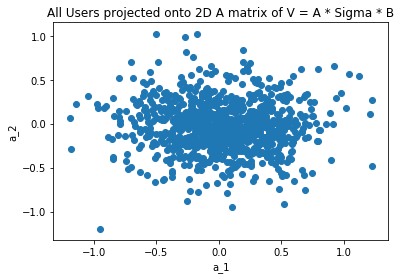

<Figure size 432x288 with 0 Axes>

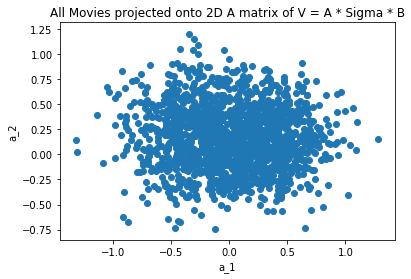

In [100]:
usx = U_surprise_proj[0]
usy = U_surprise_proj[1]

vsx = V_surprise_proj[0]
vsy = V_surprise_proj[1]

# TODO: Add title/legend and stuff
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(usx, usy)
plt.title('All Users projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

# TODO: Add title/legend and stuff
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(vsx, vsy)
plt.title('All Movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

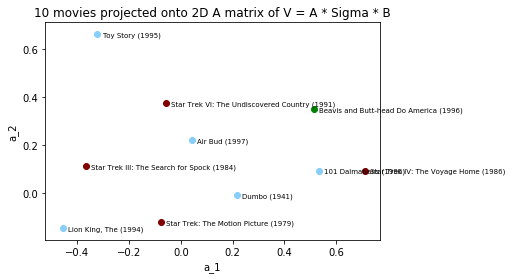

In [101]:
vsx1 = [vsx[index] for index in picked_indices]
vsy1 = [vsy[index] for index in picked_indices]

plt.clf()
for i in range(len(vsx1)):
    x, y = vsx1[i], vsy1[i]
    plt.scatter(x, y, color=toUse[i])
    plt.text(x+.02, y-.01, movieNames[picked_indices[i]], fontsize=7)
plt.title('10 movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

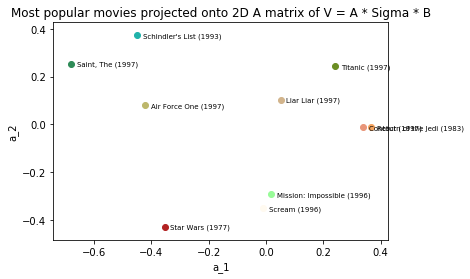

In [102]:
vsx2 = [vsx[index] for index in popularIndices]
vsy2 = [vsy[index] for index in popularIndices]

toUsePop = []
for i in range(20, 101, 8):
    toUsePop.append(sorted_names[i])

plt.clf()
for i in range(len(vsx2)):
    x, y = vsx2[i], vsy2[i]
    plt.scatter(x, y, color=toUsePop[i])
    plt.text(x+.02, y-.01, movieNames[popularIndices[i]], fontsize=7)
plt.title('Most popular movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

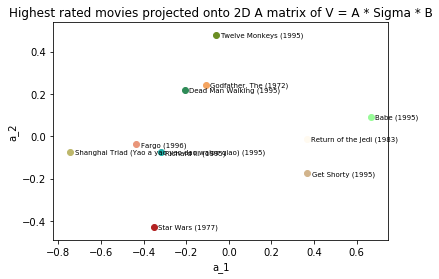

In [103]:
vsx3 = [vsx[index] for index in highestRatedIndices]
vsy3 = [vsy[index] for index in highestRatedIndices]

toUseRat = []
for i in range(20, 101, 8):
    toUseRat.append(sorted_names[i])

plt.clf()
for i in range(len(vsx3)):
    x, y = vsx3[i], vsy3[i]
    plt.scatter(x, y, color=toUseRat[i])
    plt.text(x+.02, y-.01, movieNames[highestRatedIndices[i]], fontsize=7)
plt.title('Highest rated movies projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()

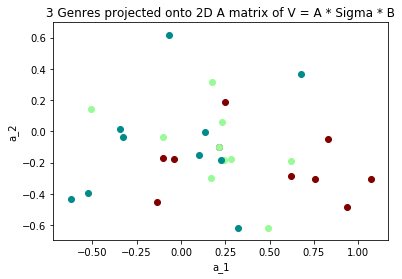

In [104]:
vbx4 = [vbx[index] for index in genreIndices]
vby4 = [vby[index] for index in genreIndices]

toUseGen = []
spam = [21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 
        76, 76, 76, 76, 76, 76, 76, 76, 76, 76,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
for i in spam:
    toUseGen.append(sorted_names[i])

plt.clf()
for i in range(len(vbx4)):
    x, y = vbx4[i], vby4[i]
    plt.scatter(x, y, color=toUseGen[i])
    # plt.text(x+.02, y-.01, movieNames[genreIndices[i]], fontsize=7)
plt.title('3 Genres projected onto 2D A matrix of V = A * Sigma * B')
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.show()